In [ ]:
!pip install torch torchvision torchaudio timm matplotlib scikit-learn --quiet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import timm
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/oral_cancer_dataset'

Mounted at /content/drive


In [ ]:
import os, shutil
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Create new merged folder
merged_dir = '/content/oral_cancer_2class'
os.makedirs(merged_dir, exist_ok=True)

for cat in ['Oral_Cancer', 'Healthy']:
    os.makedirs(os.path.join(merged_dir, cat), exist_ok=True)

# Merge images
for src_class, target_class in [
    ('OCA', 'Oral_Cancer'),
    ('OPMD', 'Oral_Cancer'),
    ('Benign', 'Healthy'),
    ('Healthy', 'Healthy')
]:
    src_path = os.path.join(base_dir, src_class)
    dest_path = os.path.join(merged_dir, target_class)
    if os.path.exists(src_path):
        for img in os.listdir(src_path):
            src = os.path.join(src_path, img)
            dst = os.path.join(dest_path, img)
            try:
                shutil.copy(src, dst)
            except:
                pass

print("Folders after merge:", os.listdir(merged_dir))
print("Oral_Cancer images:", len(os.listdir(os.path.join(merged_dir, 'Oral_Cancer'))))
print("Healthy images:", len(os.listdir(os.path.join(merged_dir, 'Healthy'))))


Folders after merge: ['Oral_Cancer', 'Healthy']
Oral_Cancer images: 1522
Healthy images: 1477


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset = datasets.ImageFolder(merged_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss/len(train_loader):.4f} | Train Acc: {acc:.2f}%")


Epoch 1/5 | Loss: 0.4017 | Train Acc: 83.24%
Epoch 2/5 | Loss: 0.0897 | Train Acc: 98.42%
Epoch 3/5 | Loss: 0.0194 | Train Acc: 99.87%
Epoch 4/5 | Loss: 0.0084 | Train Acc: 99.96%
Epoch 5/5 | Loss: 0.0101 | Train Acc: 99.83%


In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f"Validation Accuracy: {val_acc:.2f}%")


Validation Accuracy: 73.67%


In [ ]:
torch.save(model.state_dict(), '/content/oral_cancer_model.pth')
print("Model saved successfully!")


Model saved successfully!


✅ Model Performance:
Accuracy : 0.7367
Precision: 0.7264
Recall   : 0.7785
F1-Score : 0.7516

Detailed Classification Report:
              precision    recall  f1-score   support

     Healthy       0.75      0.69      0.72       293
 Oral_Cancer       0.73      0.78      0.75       307

    accuracy                           0.74       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.74      0.74      0.74       600



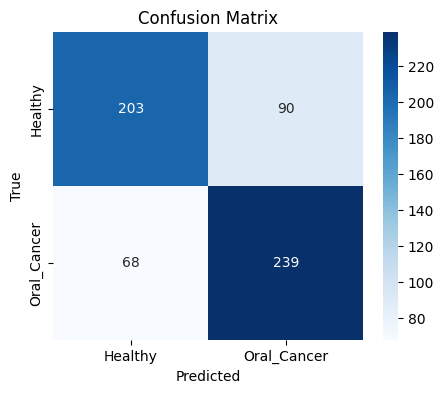

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Evaluation ---
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- Metrics ---
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')  # use 'macro' if more than 2 classes
recall    = recall_score(y_true, y_pred, average='binary')
f1        = f1_score(y_true, y_pred, average='binary')

print(f"✅ Model Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}\n")

# --- Classification Report ---
print("Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
